# Where to invest in real estate?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Getting the data

The data for this analysis is obtained from [Zillow data](http://www.zillow.com/research/data/). Please go to the source to get the raw data. The analysis was carried out in Sept 2016. This is a fun exercise and so usual disclaimers apply.

Going with the conventional wisdom that "Real estate is local", I am taking the ZHVI (Zillow house value index) and ZRI (Zillow Rent Index) for "Neighborhoods" rather than State/County/City data. Also to reduce the impact of HOA/Association fees in the analysis, I am considering only Single Family Homes

In [2]:
LATEST_MONTH = '2016-08'

# Getting ZHVI
home_values = pd.read_csv('./data/Neighborhood_Zhvi_SingleFamilyResidence.csv')
# print(home_values.head())
home_values = home_values[['RegionName','City','State',LATEST_MONTH]]
old_names = [LATEST_MONTH]
new_names = ['Zhvi']
home_values.rename(columns=dict(zip(old_names, new_names)), inplace=True)
# print(home_values.head())

# Getting ZRI
rents = pd.read_csv('./data/Neighborhood_Zri_SingleFamilyResidenceRental.csv')
# print(rents.head())
rents = rents[['RegionName','City','State',LATEST_MONTH]]
old_names = [LATEST_MONTH]
new_names = ['Zri']
rents.rename(columns=dict(zip(old_names, new_names)), inplace=True)
# print(rents.head())

# Joining the data
home_values_rents_raw = pd.merge(home_values, rents, how='inner', on=['RegionName','City','State'])
home_values_rents_raw.head()

,RegionName,City,State,Zhvi,Zri
0,Northeast Dallas,Dallas,TX,301200,1956
1,Paradise,Las Vegas,NV,222800,1284
2,Maryvale,Phoenix,AZ,139500,1057
3,Sherman Oaks,Los Angeles,CA,1110100,4365
4,South Los Angeles,Los Angeles,CA,377300,2215


In [3]:
# Checking for rent/value ratio
home_values_rents_raw['rent_by_value'] = home_values_rents_raw['Zri']/home_values_rents_raw['Zhvi']
home_values_rents_raw.sort_values(['rent_by_value'], ascending=[False], inplace=True)
home_values_rents_raw.head()

,RegionName,City,State,Zhvi,Zri,rent_by_value
3758,Coppin Heights - Ash-Co-East,Baltimore,MD,36900,1207,0.032710
3003,Broadway East,Baltimore,MD,40300,1218,0.030223
1572,Coldstream Homestead Montebello,Baltimore,MD,42500,1278,0.030071
4393,Biddle Street,Baltimore,MD,42300,1205,0.028487
4469,Franklintown Road,Baltimore,MD,44000,1194,0.027136


Ummm.. not sure if the above are "safe" neighborhoods. So will filter for neighborhoods with median home values > 200K

In [4]:
home_values_rents = home_values_rents_raw[home_values_rents_raw['Zhvi'] > 200000].copy()
home_values_rents.sort_values(['rent_by_value'], ascending=[False], inplace=True)
home_values_rents.head()

,RegionName,City,State,Zhvi,Zri,rent_by_value
752,Cherry Hill Mall,Cherry Hill,NJ,228100,1994,0.008742
1361,Erlton-Ellisburg,Cherry Hill,NJ,214700,1868,0.008701
123,Little Havana,Miami,FL,227100,1973,0.008688
1905,Barclay-Kingston,Cherry Hill,NJ,244500,2093,0.008560
2619,Firthcliffe,Cornwall,NY,230000,1968,0.008557


## Calculating Return on investment
Ideally ROI should be calculated for each sample point (home) and then the median in a neighborhood should be considered. However since the complete data is not available, Median Rent estimate (ZRI) and Median home value (ZHVI) are considered for ROI calculation as an approximation

In [5]:
# Calculating the yearly return of investment. 
# Assumptions:
# vacancy - 10% of time
# property management cost - 7% of rent after accounting for vacancy
# home insurance per annum - 0.3% of home value
# maintainence per annum - 0.2% of home value
VACANCY = 0.1
PRP_MGMT = 0.07
INSR = 0.003
MAINT = 0.002

yearly_rent = (home_values_rents['Zri']*12*(1-VACANCY-PRP_MGMT) - 
                          home_values_rents['Zhvi']*(INSR+MAINT))                          
home_values_rents['roi'] = yearly_rent*100/home_values_rents['Zhvi']

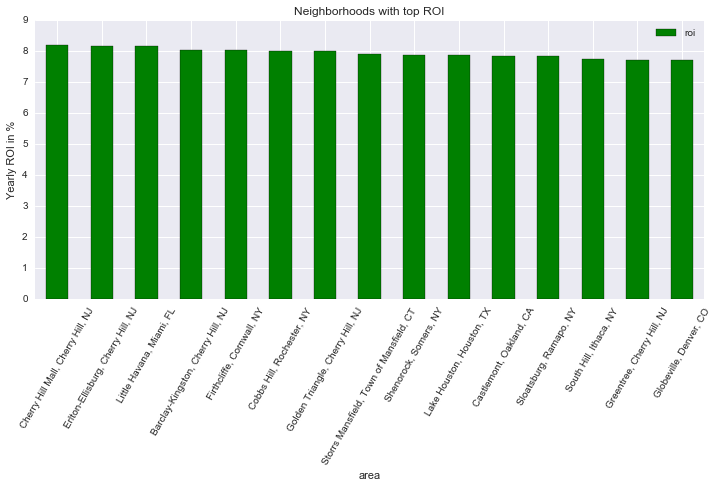

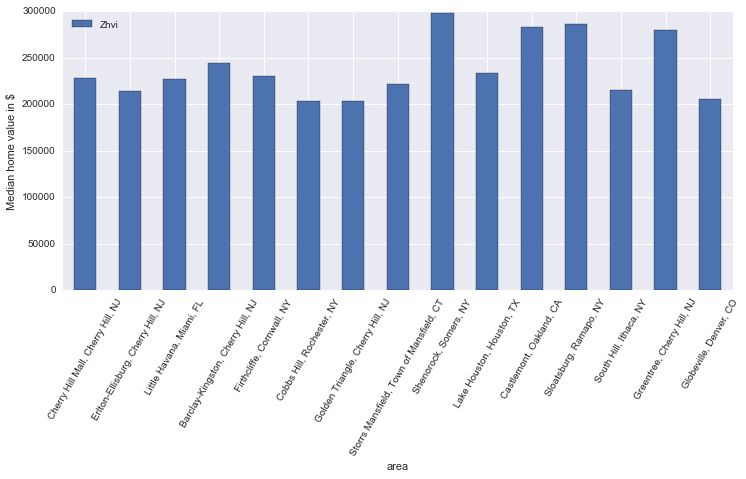

In [6]:
home_values_rents.sort_values(['roi'], ascending=[False], inplace=True)
top_picks = home_values_rents.head(15).copy()

top_picks['area'] = top_picks['RegionName']+', '+top_picks['City']+', '+top_picks['State']

fig, axs = plt.subplots(1,1,figsize=(12,5))
top_picks.plot(ax=axs, x='area', y=['roi'], kind='bar', color='green')
axs.set_ylabel('Yearly ROI in %')
axs.set_xticklabels(axs.xaxis.get_majorticklabels(), rotation=60)
axs.set_title('Neighborhoods with top ROI')

fig, axs = plt.subplots(1,1,figsize=(12,5))
top_picks.plot(ax=axs, x='area', y=['Zhvi'], kind='bar')
axs.set_ylabel('Median home value in $')
a = axs.set_xticklabels(axs.xaxis.get_majorticklabels(), rotation=60)


## Considering forcasted capital appreciation in addition to ROI

In addition to rental income, we like to consider the capital appreciation predicted in the next year to determine the overal return in the first year. ForecastYoY for "neighborhoods" are not available; so approximating it to be same as that of the respective City

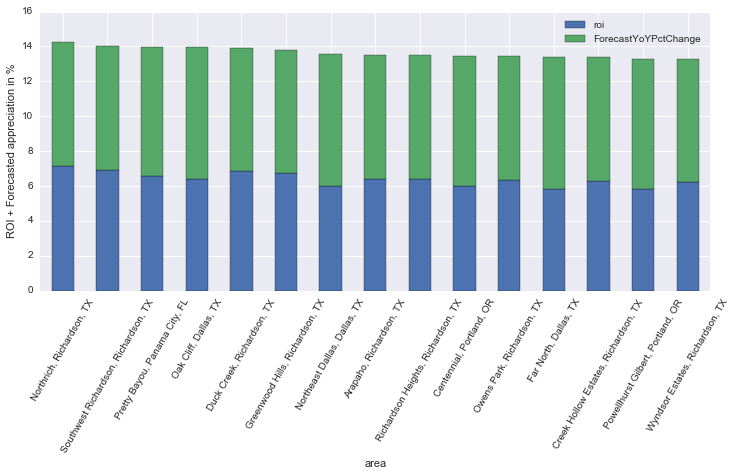

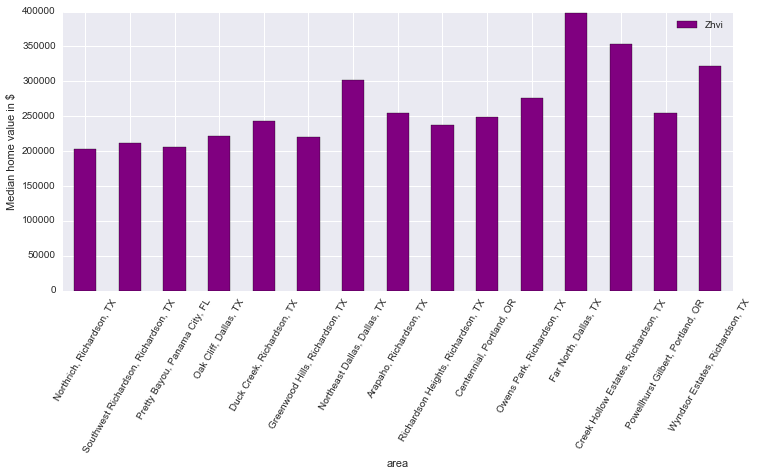

In [7]:
cap_appr = pd.read_csv('./data/AllRegionsForePublic.csv')
cap_appr = cap_appr[cap_appr['Region']=='City']
cap_appr.rename(columns={'CityName':'City'}, inplace=True)

cap_appr = cap_appr[['City','State','ForecastYoYPctChange']]

overall_data = pd.merge(home_values_rents, cap_appr, how='inner', on=['City','State'])
overall_data['roi_plus_appr'] = overall_data['roi']+overall_data['ForecastYoYPctChange']
overall_data.sort_values(['roi_plus_appr'], ascending=False, inplace=True)

overall_data['area'] = overall_data['RegionName']+', '+overall_data['City']+', '+overall_data['State']
top_picks = overall_data.head(15).copy()

fig, axs = plt.subplots(1,1,figsize=(12,5))
top_picks.plot(ax=axs, x='area', y=['roi','ForecastYoYPctChange'], stacked=True, kind='bar')
axs.set_ylabel('ROI + Forecasted appreciation in %')
a = axs.set_xticklabels(axs.xaxis.get_majorticklabels(), rotation=60)

fig, axs = plt.subplots(1,1,figsize=(12,5))
top_picks.plot(ax=axs, x='area', y=['Zhvi'], kind='bar', color='purple')
axs.set_ylabel('Median home value in $')
a = axs.set_xticklabels(axs.xaxis.get_majorticklabels(), rotation=60)